[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hmd-dsai/ifood-marketing-campaign-analysis/blob/main/notebook/ifood_marketing_campaign_analysis.ipynb)

*Click the badge above to open and run this notebook interactively in Google Colab.*  

# About me and this project

Hello! My name is Hoàng Minh Đức, and I am currently a 12th-grade student in Vietnam. I aspire to pursue a career in Data Science and Analytics (DS/AI).

This is my first large project in DS/DA, and while it may not be perfect, I hope it will serve as a reflection of my journey and ability to apply theoretical knowledge to real-world scenarios, as well as to grow further in this discipline.

Please note that the contents of this project **may not** be used or copied without my consent.

# Dataset context

The dataset utilized in this project was sourced from [Github](https://github.com/nailson/ifood-data-business-analyst-test) and pertains to a marketing campaign for iFood. It was originally designed for hiring Data Analysts for the iFood Brain team.

**Reference date:** 28/5/2020 (This date is important because variables such as `Customer_Days` are calculated relative to it.)

## My Objectives:
- Conduct Exploratory Data Analysis (EDA) to gain actionable business insights.
- Compare a selected-feature model and an all-feature model
- Develop a prediction model to apply to the broader customer base.

# Load Libraries and Dataset + Clean Dataset

What I did in this section:
- Explain dataset context
- Import necessary libraries
- Load dataset
- Clean dataset

Clarification of dataset cleaning:
- Drop non-meaningful features
- Drop rows with empty values or outlier values
- Convert some features to more actionable ones
- One-hot encode features with categorical variables
- Create some features with aggregate values

In [1]:
#@title [Code] Load Libraries and Dataset + Clean Dataset

# Load Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random

# Suppress TensorFlow device/optimization logs and common UserWarnings for clean output
import os, warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # filters info + warning, keeps only errors
warnings.filterwarnings("ignore", category=UserWarning)

# Load Dataset
path = "../data/ml_project1_data.csv"
ifood_df_raw = pd.read_csv(path)

print("Libraries and dataset loaded successfully")


# Clean Dataset
ifood_df = ifood_df_raw.copy()

ifood_df.drop(columns=["Z_CostContact", "Z_Revenue"], inplace=True) # Features with constant values
ifood_df.drop(columns=["ID"], inplace=True) # ID is irrelevant

ifood_df = ifood_df[~ifood_df["Marital_Status"].isin(["Absurd", "Alone", "YOLO"])] # Remove outliers
ifood_df = ifood_df[ifood_df["Income"] <= 200000] # Remove outliers
ifood_df = ifood_df.dropna() # Drop rows with empty values

ifood_df["Dt_Customer"] = pd.to_datetime(ifood_df["Dt_Customer"]) # Convert Dt_Customer to Customer_Days
reference_date = pd.Timestamp("2020-05-28")
ifood_df["Customer_Days"] = (reference_date - ifood_df["Dt_Customer"]).dt.days
ifood_df.drop(columns=["Dt_Customer"], inplace=True)

ifood_df["Age"] = reference_date.year - ifood_df["Year_Birth"] # Convert Year_Birth to Age
ifood_df.drop(columns=["Year_Birth"], inplace=True)

ifood_df = pd.get_dummies(ifood_df, columns=["Education", "Marital_Status"], prefix=["education", "marital"], drop_first=False).astype(int) # One-hot encode categorical variables

ifood_df["Total_Children"] = ifood_df["Kidhome"] + ifood_df["Teenhome"] # Create some aggregate columns
ifood_df["MntFoodProducts"] = ifood_df["MntWines"] + ifood_df["MntFruits"] + ifood_df["MntMeatProducts"] + ifood_df["MntFishProducts"] + ifood_df["MntSweetProducts"]
ifood_df["MntTotal"] = ifood_df["MntFoodProducts"] + ifood_df["MntGoldProds"]
ifood_df["AcceptedCmpAll"] = ifood_df["AcceptedCmp1"] + ifood_df["AcceptedCmp2"] + ifood_df["AcceptedCmp3"] + ifood_df["AcceptedCmp4"] + ifood_df["AcceptedCmp5"]

print("Data cleaned successfully")

Libraries and dataset loaded successfully
Data cleaned successfully


# Exploratory Data Analysis (EDA)

What I did in this section:
- Evaluate correlation coefficient between each feature and the label (Response)
- Explore relationship between different features
- Conclude gathered insights and recommended business actions

Features with high absolute correlation (>= 0.15):

                     Correlation
AcceptedCmpAll          0.425914
AcceptedCmp5            0.322148
AcceptedCmp1            0.295754
MntTotal                0.265496
MntFoodProducts         0.264923
AcceptedCmp3            0.252298
MntWines                0.247577
MntMeatProducts         0.240314
NumCatalogPurchases     0.219453
Customer_Days           0.196844
AcceptedCmp4            0.181609
AcceptedCmp2            0.170252
Income                  0.161454
NumWebPurchases         0.152959
Teenhome               -0.155906
Total_Children         -0.168763
Recency                -0.199869


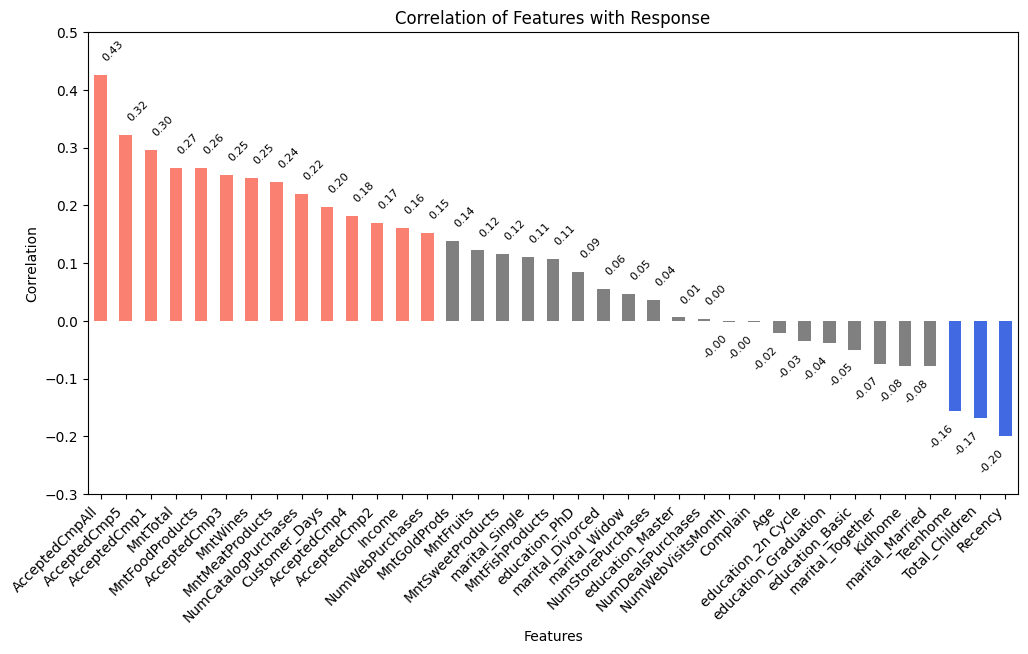

In [2]:
#@title [Code] Correlation between features and label

# Evaluate correlations with "Response", highlighting features with |correlation| >= 0.15
correlation_results = {}

for column in ifood_df.columns:
    if column != "Response":
        r_pb = np.corrcoef(ifood_df[column], ifood_df["Response"])[0, 1] # Point-Biserial Correlation
        correlation_results[column] = r_pb

correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=["Correlation"])
correlation_df = correlation_df.sort_values(by="Correlation", ascending=False)

high_abs_corr = correlation_df[abs(correlation_df["Correlation"]) >= 0.15]
print("Features with high absolute correlation (>= 0.15):\n")
print(high_abs_corr)


# Visualize using bar graph
colors = ["salmon" if val >= 0.15 else "royalblue" if val <= -0.15 else "gray" for val in correlation_df["Correlation"]]

plt.figure(figsize=(12, 6))
correlation_df["Correlation"].plot(kind="bar", color=colors)
plt.title("Correlation of Features with Response")
plt.ylabel("Correlation")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.ylim(-0.3, 0.5)

for i, val in enumerate(correlation_df["Correlation"]):
    plt.text(
        i,
        val + (0.02 if val > 0 else -0.02),
        f"{val:.2f}",
        ha="left" if val > 0 else "right",
        va="bottom" if val > 0 else "top",
        fontsize=8,
        rotation=45,
      )

plt.show()

Using graphs below and correlation values from above, we can gather these insights:
- More campaigns accepted in the past/ More spending = More likely to accept last campaign
- Higher income = higher spending, but not a significant higher chance of response



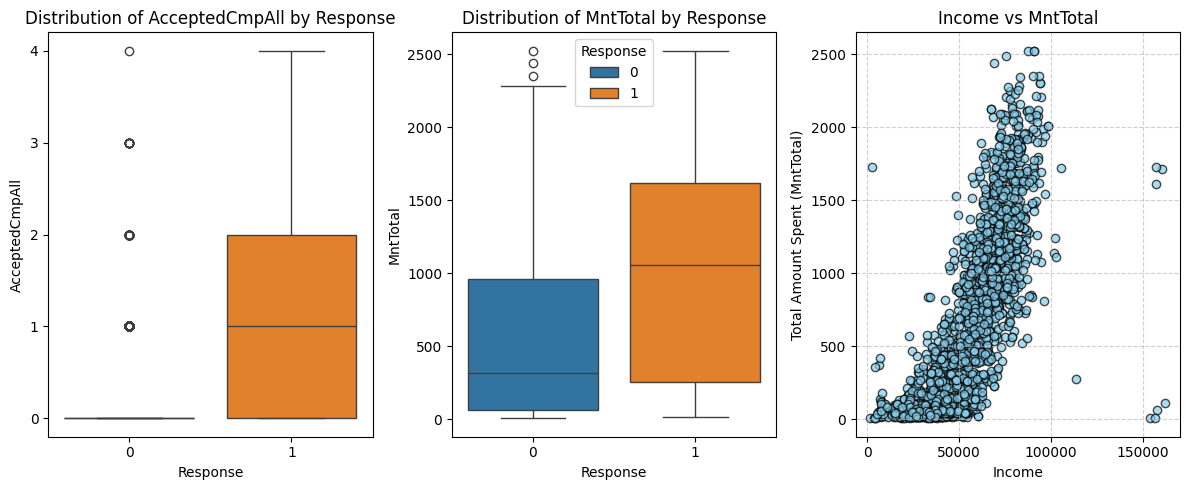

In [3]:
#@title [Code] Correlation between some feature pairs

# Insights
print(
    f'Using graphs below and correlation values from above, we can gather these insights:\n'
    f'- More campaigns accepted in the past/ More spending = More likely to accept last campaign\n'
    f'- Higher income = higher spending, but not a significant higher chance of response\n'
)

plt.figure(figsize=(12, 5))

# AcceptedCmpAll vs Response
plt.subplot(1, 3, 1)
sns.boxplot(x="Response", y="AcceptedCmpAll", data=ifood_df, legend=False, hue="Response")
plt.title("Distribution of AcceptedCmpAll by Response")
plt.xlabel("Response")
plt.ylabel("AcceptedCmpAll")
plt.yticks([0, 1, 2, 3, 4])

# MntTotal vs Response
plt.subplot(1, 3, 2)
sns.boxplot(x="Response", y="MntTotal", data=ifood_df, hue="Response")
plt.title("Distribution of MntTotal by Response")
plt.xlabel("Response")
plt.ylabel("MntTotal")

# Income vs MntTotal (outlier excluded)
plt.subplot(1, 3, 3)
plt.scatter(ifood_df["Income"], ifood_df["MntTotal"], alpha=0.7, color="skyblue", edgecolor="k")
plt.title("Income vs MntTotal")
plt.xlabel("Income")
plt.ylabel("Total Amount Spent (MntTotal)")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

Insights:
- In total, customers spend most on Wine, then Meat, then other categories



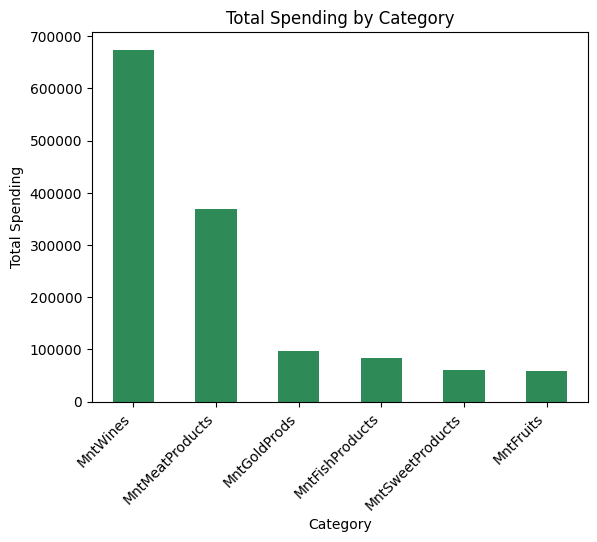

In [4]:
#@title [Code] Spending Behavior

# Insights
print(
    f'Insights:\n'
    f'- In total, customers spend most on Wine, then Meat, then other categories\n'
)

categories = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
ifood_df[categories].sum().sort_values(ascending=False).plot(kind="bar", title="Total Spending by Category", color="seagreen")
plt.xlabel("Category")
plt.ylabel("Total Spending")
plt.xticks(rotation=45, ha="right")
plt.show()

Insights:
- Higher education level = higher chance of response
- Non-cohabiting = higher chance of response
- Higher age = lower chance of response
=> Marketing has to be adjusted for different groups (for example, focusing on people with higher education levels, people living alone, and younger people)



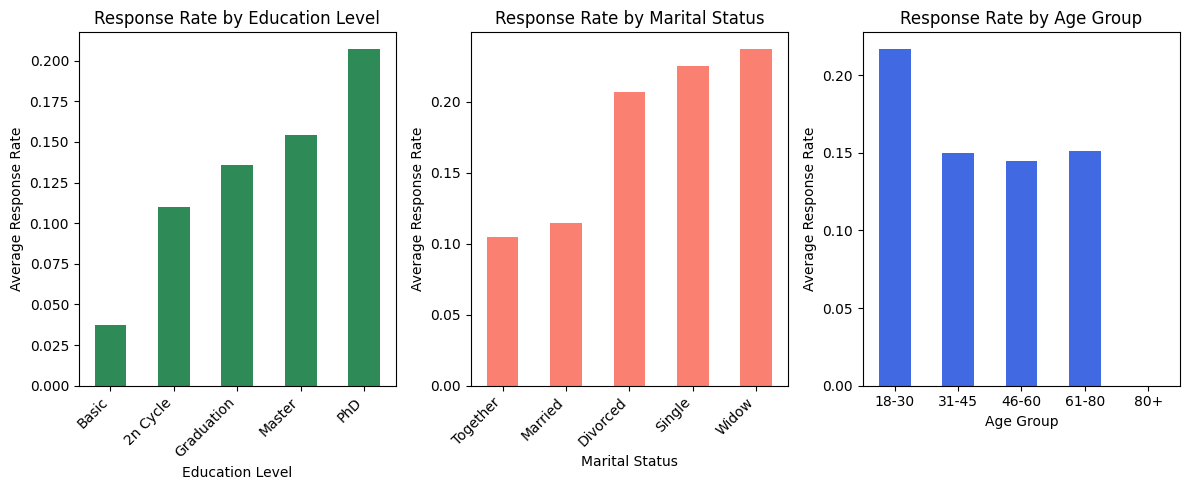

In [5]:
#@title [Code] Demographics vs Response

# Insights
print(
    f'Insights:\n'
    f'- Higher education level = higher chance of response\n'
    f'- Non-cohabiting = higher chance of response\n'
    f'- Higher age = lower chance of response\n'
    f'=> Marketing has to be adjusted for different groups (for example, focusing on people with higher education levels, people living alone, and younger people)\n'
)

plt.figure(figsize=(12, 5))

# Response by Education level
ifood_df['Education'] = ifood_df[['education_Basic', 'education_Graduation', 'education_2n Cycle', 'education_Master', 'education_PhD']].idxmax(axis=1).str.replace('education_', '')
education_response = ifood_df.groupby("Education")["Response"].mean()
education_response = education_response.sort_values()
plt.subplot(1, 3, 1)
education_response.plot(kind="bar", color="seagreen", title="Response Rate by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Average Response Rate")
plt.xticks(rotation=45, ha="right")

# Response by Marital Status
ifood_df['Marital_Status'] = ifood_df[['marital_Divorced', 'marital_Married', 'marital_Single', 'marital_Together', 'marital_Widow']].idxmax(axis=1).str.replace('marital_', '')
marital_response = ifood_df.groupby("Marital_Status")["Response"].mean()
marital_response = marital_response.sort_values()
plt.subplot(1, 3, 2)
marital_response.plot(kind="bar", color="salmon", title="Response Rate by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Average Response Rate")
plt.xticks(rotation=45, ha="right")

# Response by age group
ifood_df["Age_Group"] = pd.cut(ifood_df["Age"], bins=[18, 30, 45, 60, 80, 150], labels=["18-30", "31-45", "46-60", "61-80", "80+"])
age_response = ifood_df.groupby("Age_Group", observed=False)["Response"].mean()
plt.subplot(1, 3, 3)
age_response.plot(kind="bar", color="royalblue", title="Response Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Response Rate")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

if 'Education' in ifood_df.columns:
    ifood_df.drop(columns=['Education'], inplace=True)
if 'Marital_Status' in ifood_df.columns:
    ifood_df.drop(columns=['Marital_Status'], inplace=True)
if 'Age_Group' in ifood_df.columns:
    ifood_df.drop(columns=['Age_Group'], inplace=True)

Insights:
- More children = lower chance of response and lower spending



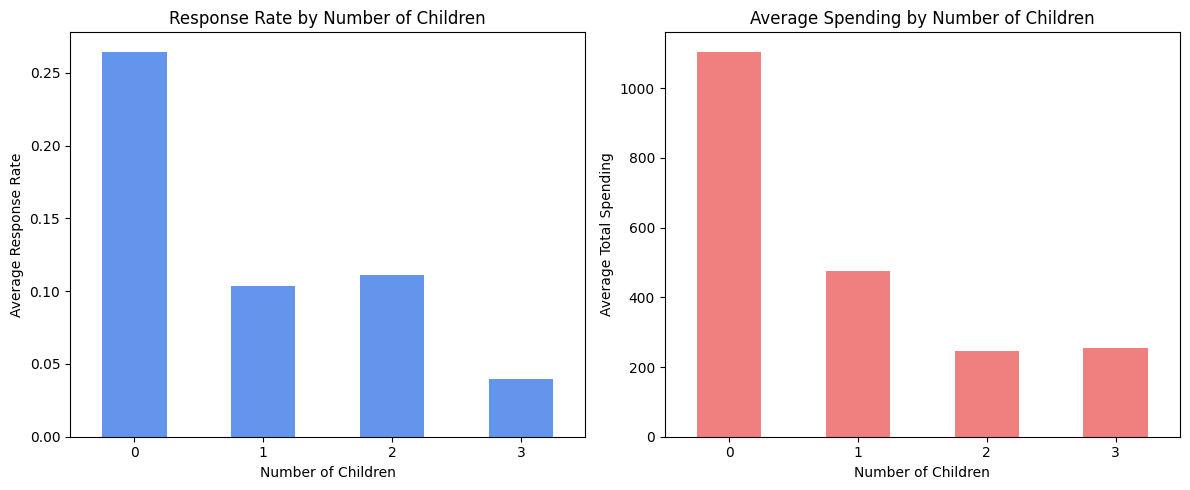

In [6]:
#@title [Code] Number of children vs Response and Spending

# Insights
print(
    f'Insights:\n'
    f'- More children = lower chance of response and lower spending\n'
)

children_response = ifood_df.groupby("Total_Children")["Response"].mean()
children_spending = ifood_df.groupby("Total_Children")["MntTotal"].mean()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
children_response.plot(kind="bar", color="cornflowerblue")
plt.title("Response Rate by Number of Children")
plt.xlabel("Number of Children")
plt.ylabel("Average Response Rate")
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
children_spending.plot(kind="bar", color="lightcoral")
plt.title("Average Spending by Number of Children")
plt.xlabel("Number of Children")
plt.ylabel("Average Total Spending")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Gathered Insights and Suggested Business Actions

- Customers who accepted more past campaigns and spend more on products are more likely to respond to the last campaign.
- Higher income correlates to higher spending but not a significant higher chance of response.
- Marketing may focus on wine and meat products as they generate perceivably more aggregate revenue.
- Marketing should target at customers who have high education level, are not cohabiting, and are of young age.
- Marketing should be adjusted for families with children who are less likely to respond and who spend less.

# Machine Learning Preparations

What I did in this section:
- Standardize data using Z-score normalization and define function for standardizing future data
- Split dataset into Train set and Test set; split each set into Features and Label
- Define classes for input and storing model
- Define relevant functions for Machine learning, plotting, comparing performance between train/test set and between different experiments

In [7]:
#@title [Code] Data Standardization + Split

# Standardize data using Z-score normalization
stats = {}
standardized_data = ifood_df.copy()
for column in standardized_data.columns:
    if pd.api.types.is_numeric_dtype(standardized_data[column]):
        # Ignore columns which are pseudobinary (integers with values only of 0 or 1)
        unique_values = standardized_data[column].unique()
        if not set(unique_values).issubset({0, 1}):
            mean = standardized_data[column].mean()
            std = standardized_data[column].std()
            standardized_data[column] = (standardized_data[column] - mean) / std
            stats[column] = {'mean': mean, 'std': std}

# Define function for standardizing future datasets
def standardize(new_data, stats):
    for column in new_data.columns:
        if column in stats:
            mean = stats[column]['mean']
            std = stats[column]['std']
            new_data[column] = (new_data[column] - mean) / std
    return new_data

print("Data standardized successfully")


# Train-Test split
number_samples = len(standardized_data)
index_80th = round(number_samples * 0.8)

shuffled_data = standardized_data.sample(frac=1, random_state=42)
train_data = shuffled_data.iloc[0:index_80th]
test_data = shuffled_data.iloc[index_80th:]

print("Data split successfully")


# Feature-Label split
train_features = train_data.drop(columns=["Response"])
train_labels = train_data["Response"]

test_features = test_data.drop(columns=["Response"])
test_labels = test_data["Response"]

print("Features and labels split successfully")

Data standardized successfully
Data split successfully
Features and labels split successfully


In [8]:
#@title [Code] Define classes

from dataclasses import dataclass

# List the hyperparameters and input features for training a model
@dataclass
class Settings:
  learning_rate: float
  number_epochs: int
  batch_size: int
  classification_threshold: float
  input_features: list[str]


# Store settings and resulting model
@dataclass
class Experiment:
  name: str
  settings: Settings
  model: keras.Model
  epochs: np.ndarray
  metrics_history: keras.callbacks.History

  # Get the final value of the given metric.
  def get_final_metric_value(self, metric_name: str) -> float:
    if metric_name not in self.metrics_history:
      raise ValueError(
          f'Unknown metric {metric_name}: available metrics are {list(self.metrics_history.columns)}'
      )
    return self.metrics_history[metric_name].iloc[-1]

print('Settings and Experiment classes defined')

Settings and Experiment classes defined


In [9]:
#@title [Code] Define Machine learning functions

# Define model creating function.
def create_model(
    settings: Settings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:

  model_inputs = [
      keras.Input(name=feature, shape=(1,)) for feature in settings.input_features
  ]

  concatenated_inputs = keras.layers.Concatenate()(model_inputs)
  dense = keras.layers.Dense(
      units=1, input_shape=(1,), name='dense_layer', activation=keras.activations.sigmoid
  )
  model_output = dense(concatenated_inputs)
  model = keras.Model(inputs=model_inputs, outputs=model_output)

  model.compile(
      optimizer=keras.optimizers.RMSprop(
          settings.learning_rate
      ),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics,
  )
  return model


# Define model training function
def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: Settings,
) -> Experiment:

  features = {
      feature_name: np.array(dataset[feature_name])
      for feature_name in settings.input_features
  }

  history = model.fit(
      x=features,
      y=labels,
      batch_size=settings.batch_size,
      epochs=settings.number_epochs,
  )

  return Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )

print('create_model and train_model functions defined')


# Define plotting function
def plot_experiment_metrics(
    experiment: Experiment,
    metrics: list[str],
):

  plt.figure(figsize=(12, 8))

  for metric in metrics:
    plt.plot(
        experiment.epochs, experiment.metrics_history[metric], label=metric
    )

  plt.xlabel("Epoch")
  plt.ylabel("Metric value")
  plt.grid()
  plt.legend()

print('plot_experiment_metrics function defined')

create_model and train_model functions defined
plot_experiment_metrics function defined


In [10]:
#@title [Code] Define function to compare performance

# Define function to compare experiments
def compare_experiment(experiments: list[Experiment],
                       metrics_of_interest: list[str],
                       test_dataset: pd.DataFrame,
                       test_labels: np.array):

  for metric in metrics_of_interest:
    for experiment in experiments:
      if metric not in experiment.metrics_history:
        raise ValueError(f'Metric {metric} not available for experiment {experiment.name}')

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(2, 1, 1)

  colors = [f'C{i}' for i in range(len(experiments))]
  markers = ['.', '*', 'X', 'p', 's']
  marker_size = 10

  ax.set_title('Train metrics')
  for i, metric in enumerate(metrics_of_interest):
    for j, experiment in enumerate(experiments):
      plt.plot(experiment.epochs, experiment.metrics_history[metric], markevery=4,
               marker=markers[i], markersize=marker_size, color=colors[j])

  legend_handles = []
  for i, metric in enumerate(metrics_of_interest):
    legend_handles.append(Line2D([0], [0], label=metric, marker=markers[i],
                                 markersize=marker_size, c='k'))
  for i, experiment in enumerate(experiments):
    legend_handles.append(Line2D([0], [0], label=experiment.name, color=colors[i]))

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Metric value")
  ax.grid()
  ax.legend(handles=legend_handles)

  ax = fig.add_subplot(2, 1, 2)
  spacing = 0.3
  n_bars = len(experiments)
  bar_width = (1 - spacing)/n_bars
  for i, experiment in enumerate(experiments):
    test_metrics = evaluate_experiment(experiment, test_dataset, test_labels)
    x = np.arange(len(metrics_of_interest)) + bar_width * (i + 1/2 - n_bars/2)
    ax.bar(x, [test_metrics[metric] for metric in metrics_of_interest], width=bar_width, label=experiment.name)
  ax.set_xticks(np.arange(len(metrics_of_interest)), metrics_of_interest)

  ax.set_title('Test metrics')
  ax.set_ylabel('Metric value')
  ax.set_axisbelow(True) # Put the grid behind the bars
  ax.grid()
  ax.legend()


# Define functions to compare train/test sets
def evaluate_experiment(
    experiment: Experiment, test_dataset: pd.DataFrame, test_labels: np.array
) -> dict[str, float]:
  features = {
      feature_name: np.array(test_dataset[feature_name])
      for feature_name in experiment.settings.input_features
  }
  return experiment.model.evaluate(
      x=features,
      y=test_labels,
      batch_size=settings.batch_size, # type: ignore
      verbose=0,
      return_dict=True,
  )

def compare_train_test(experiment: Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')

print('compare_experiment, evaluate_experiment and compare_train_test functions defined')

compare_experiment, evaluate_experiment and compare_train_test functions defined


# Model training and comparison

What I did in this section:
- Use features with high correlation to Label as input for the selected-feature model
- Invoke training on selected-feature model and all-feature model
- Compare performace between train/test sets and between 2 models

In [11]:
#@title [Code] Select input features

# Here, I selected features with high absolute correlations with the Label
input_features=high_abs_corr.index.tolist()
print('Input features defined:')
print(input_features)

Input features defined:
['AcceptedCmpAll', 'AcceptedCmp5', 'AcceptedCmp1', 'MntTotal', 'MntFoodProducts', 'AcceptedCmp3', 'MntWines', 'MntMeatProducts', 'NumCatalogPurchases', 'Customer_Days', 'AcceptedCmp4', 'AcceptedCmp2', 'Income', 'NumWebPurchases', 'Teenhome', 'Total_Children', 'Recency']


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5051 - auc: 0.7536 - loss: 0.6717 - precision: 0.2155 - recall: 0.8750
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5119 - auc: 0.7597 - loss: 0.6563 - precision: 0.2185 - recall: 0.8788
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5215 - auc: 0.7652 - loss: 0.6435 - precision: 0.2225 - recall: 0.8826
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5260 - auc: 0.7706 - loss: 0.6315 - precision: 0.2237 - recall: 0.8788
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5340 - auc: 0.7764 - loss: 0.6201 - precision: 0.2268 - recall: 0.8788
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5402 - auc: 0.7823 - loss: 0.6091 - precision: 0.2287 - recall: 0.8750
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5476 - auc: 0.7873 - loss: 0.5987 - precision: 0.2312 - recall: 0.8712
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s

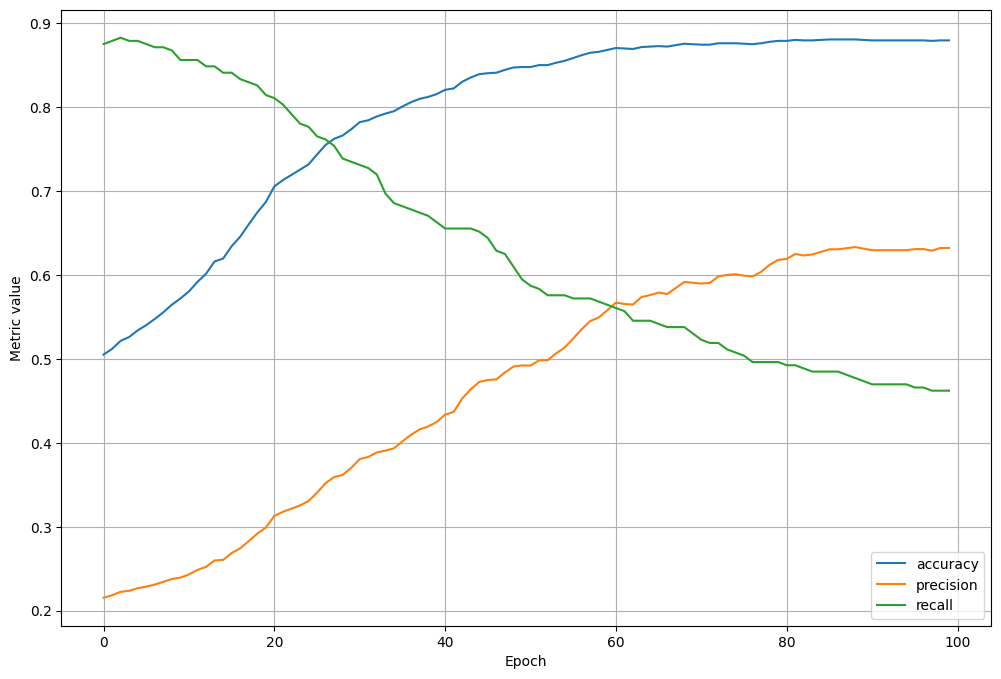

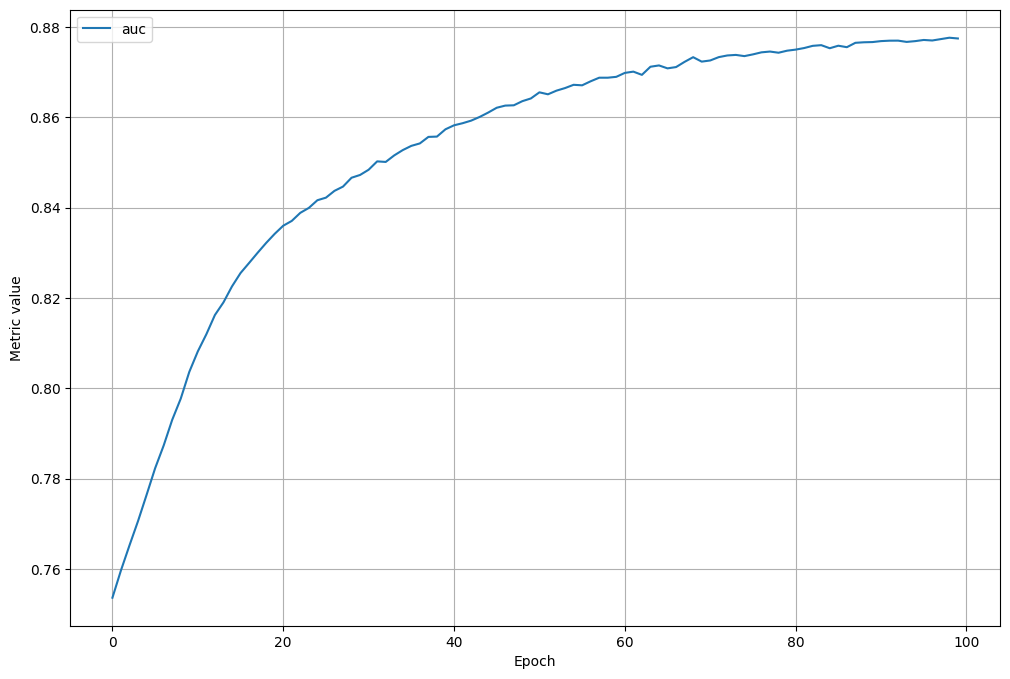

In [12]:
#@title [Code] Invoke training on selected features

# Define random seed
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


# Input settings
settings = Settings(
    learning_rate=0.001,
    number_epochs=100,
    batch_size=100,
    classification_threshold=0.4,
    input_features=input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',
        threshold=settings.classification_threshold,
    ),
    keras.metrics.Precision(
        name='precision',
        thresholds=settings.classification_threshold,
    ),
    keras.metrics.Recall(
        name='recall',
        thresholds=settings.classification_threshold,
    ),
    keras.metrics.AUC(
        num_thresholds=100,
        name='auc',
    ),
]


# Create model
model = create_model(settings, metrics)

# Train model
experiment = train_model(
    'baseline', model, train_features, train_labels, settings
)

# Compare metrics epoch
plot_experiment_metrics(experiment, ['accuracy', 'precision', 'recall'])
plot_experiment_metrics(experiment, ['auc'])

In [13]:
#@title [Code] Evaluate selected-feature model against test set

test_metrics = evaluate_experiment(experiment, test_features, test_labels)
compare_train_test(experiment, test_metrics)

Comparing metrics between train and test:
------
Train accuracy: 0.8794
Test accuracy:  0.8824
------
Train auc: 0.8774
Test auc:  0.8589
------
Train loss: 0.2957
Test loss:  0.3068
------
Train precision: 0.6321
Test precision:  0.6522
------
Train recall: 0.4621
Test recall:  0.4545


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4213 - auc: 0.5558 - loss: 0.6729 - precision: 0.1640 - recall: 0.7008
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4462 - auc: 0.5859 - loss: 0.6427 - precision: 0.1713 - recall: 0.7045
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4723 - auc: 0.6071 - loss: 0.6187 - precision: 0.1770 - recall: 0.6932
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5011 - auc: 0.6260 - loss: 0.5966 - precision: 0.1874 - recall: 0.7008
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5317 - auc: 0.6442 - loss: 0.5758 - precision: 0.1983 - recall: 0.7008
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5555 - auc: 0.6604 - loss: 0.5562 - precision: 0.2089 - recall: 0.7083
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5815 - auc: 0.6771 - loss: 0.5377 - precision: 0.2169 - recall: 0.6894
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s

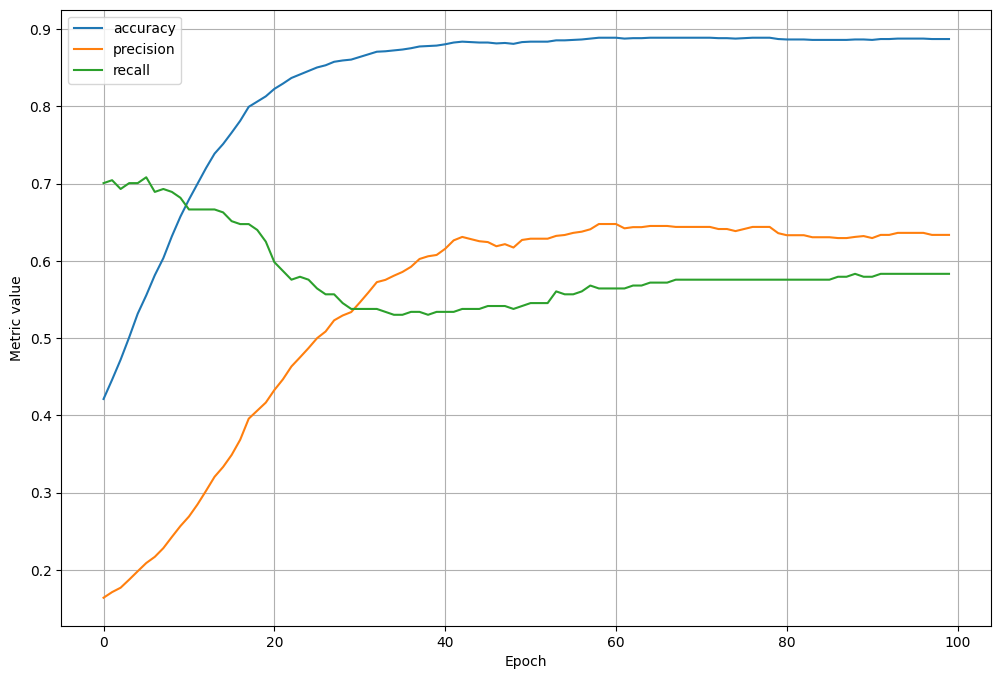

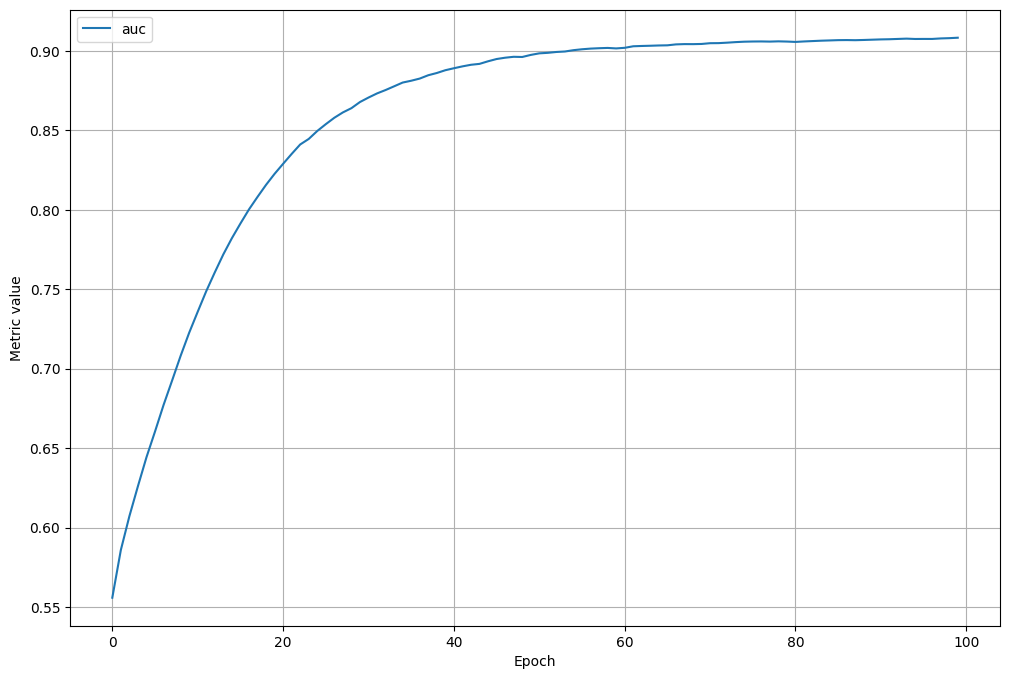

In [14]:
#@title [Code] Invoke training on all features

# Define random seed
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


# Input features and settings
all_input_features=train_features.columns.tolist()

settings_all_features = Settings(
    learning_rate=0.001,
    number_epochs=100,
    batch_size=100,
    classification_threshold=0.35,
    input_features=all_input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',
        threshold=settings_all_features.classification_threshold,
    ),
    keras.metrics.Precision(
        name='precision',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.Recall(
        name='recall',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.AUC(
        num_thresholds=100,
        name='auc',
    ),
]


# Create model
model_all_features = create_model(settings_all_features, metrics)


# Train model
experiment_all_features = train_model(
    'all features',
    model_all_features,
    train_features,
    train_labels,
    settings_all_features,
)


# Compare metrics vs epoch
plot_experiment_metrics(experiment_all_features, ['accuracy', 'precision', 'recall'])
plot_experiment_metrics(experiment_all_features, ['auc'])

In [15]:
#@title [Code] Evaluate all-feature model against test set

test_metrics_all_features = evaluate_experiment(
    experiment_all_features, test_features, test_labels
)
compare_train_test(experiment_all_features, test_metrics_all_features)

Comparing metrics between train and test:
------
Train accuracy: 0.8873
Test accuracy:  0.8914
------
Train auc: 0.9084
Test auc:  0.9072
------
Train loss: 0.2559
Test loss:  0.2607
------
Train precision: 0.6337
Test precision:  0.6800
------
Train recall: 0.5833
Test recall:  0.5152


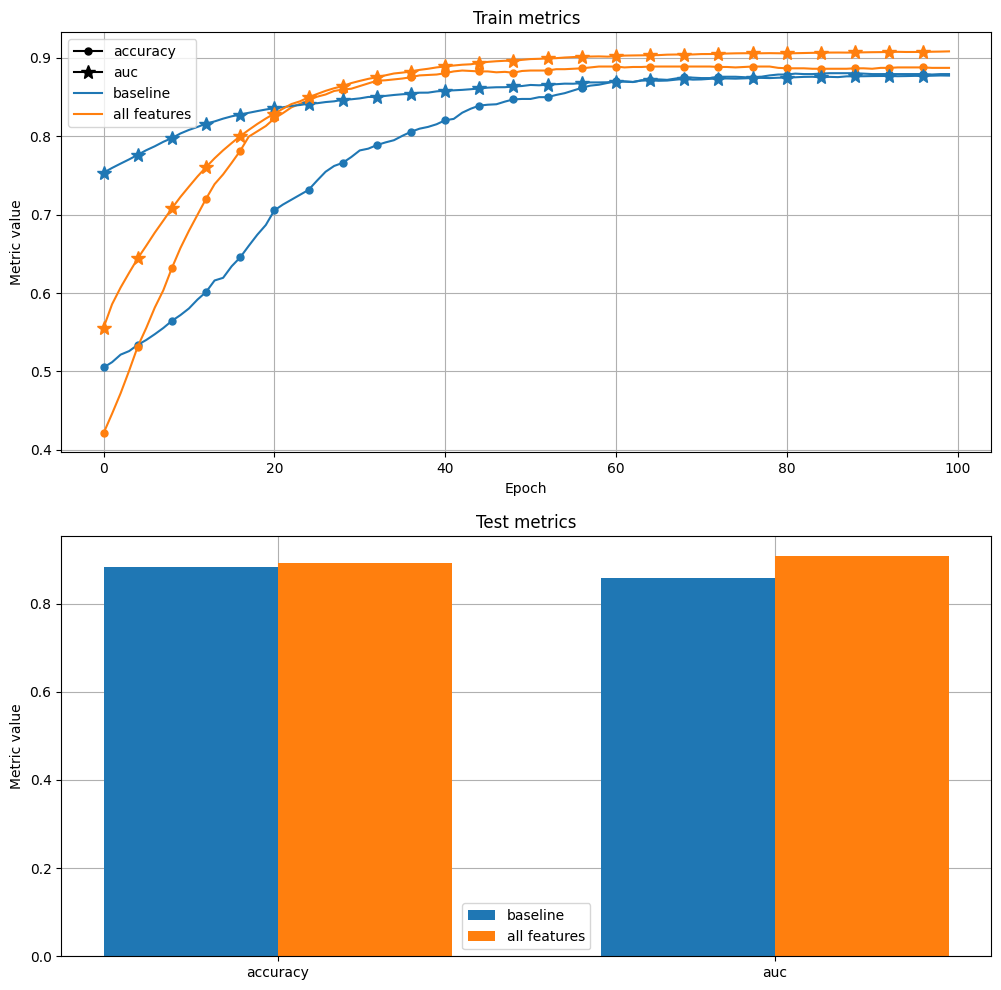

In [16]:
#@title [Code] Compare 2 models (Show code to customize)

compare_experiment([experiment, experiment_all_features],
                   ['accuracy', 'auc'], # Edit here
                   test_features, test_labels)

# Here, I only selected 2 features for better graph readability
# You may customize the selected features by editing the line specified by "Edit here"
# Select features from this set: ['accuracy', 'loss', 'precision', 'recall', 'auc']

# Predicting Customer Response

What I did in this section:
- Define a sample customer profile (you may alter the data to experiment on your own)
- Run the prediction model (using selected features and all features)

In [17]:
#@title [Code] Define customer's profile (Show code to customize)

# Define a sample customer profile
# You may define your own customer profile by modifying the variables in this dictionary
sample_customer = {
    "Income": 58293,
    "Kidhome": 1,
    "Teenhome": 0,
    "Recency": 10,
    "MntWines": 373,
    "MntFruits": 43,
    "MntMeatProducts": 118,
    "MntFishProducts": 46,
    "MntSweetProducts": 27,
    "MntGoldProds": 15,
    "NumDealsPurchases": 5,
    "NumWebPurchases": 5,
    "NumCatalogPurchases": 3,
    "NumStorePurchases": 6,
    "NumWebVisitsMonth": 5,
    "AcceptedCmp3": 0,
    "AcceptedCmp4": 1,
    "AcceptedCmp5": 1,
    "AcceptedCmp1": 0,
    "AcceptedCmp2": 0,
    "Complain": 0,
    "Customer_Days": 2320,
    "Age": 39,
    "Education": "PhD", # Choose from: ["Basic", "Graduation", "2n Cycle", "Master", "PhD"]
    "Marital_Status": "Married", # Choose from: ["Single", "Together", "Married", "Divorced", "Widow"]
}


# Clean input for prediction model
education_dummies = {
    "education_Basic": 0,
    "education_Graduation": 0,
    "education_2n Cycle": 0,
    "education_Master": 0,
    "education_PhD": 0,
}
if sample_customer["Education"] == "Basic":
    education_dummies["education_Basic"] = 1
elif sample_customer["Education"] == "Graduation":
    education_dummies["education_Graduation"] = 1
elif sample_customer["Education"] == "2n Cycle":
    education_dummies["education_2n Cycle"] = 1
elif sample_customer["Education"] == "Master":
    education_dummies["education_Master"] = 1
elif sample_customer["Education"] == "PhD":
    education_dummies["education_PhD"] = 1
else:
    raise ValueError(f"Invalid education level: '{sample_customer['Education']}'.")

marital_dummies = {
    "marital_Divorced": 0,
    "marital_Married": 0,
    "marital_Single": 0,
    "marital_Together": 0,
    "marital_Widow": 0,
}
if sample_customer["Marital_Status"] == "Divorced":
    marital_dummies["marital_Divorced"] = 1
elif sample_customer["Marital_Status"] == "Married":
    marital_dummies["marital_Married"] = 1
elif sample_customer["Marital_Status"] == "Single":
    marital_dummies["marital_Single"] = 1
elif sample_customer["Marital_Status"] == "Together":
    marital_dummies["marital_Together"] = 1
elif sample_customer["Marital_Status"] == "Widow":
    marital_dummies["marital_Widow"] = 1
else:
    raise ValueError(f"Invalid marital status: '{sample_customer['Marital_Status']}'.")

del sample_customer["Education"]
del sample_customer["Marital_Status"]

sample_customer.update(education_dummies)
sample_customer.update(marital_dummies)

sample_customer["Total_Children"] = (
    sample_customer["Kidhome"] +
    sample_customer["Teenhome"]
)
sample_customer["MntFoodProducts"] = (
    sample_customer["MntFruits"] +
    sample_customer["MntMeatProducts"] +
    sample_customer["MntFishProducts"] +
    sample_customer["MntSweetProducts"] +
    sample_customer["MntWines"]
)
sample_customer["MntTotal"] = (
    sample_customer["MntFoodProducts"] +
    sample_customer["MntGoldProds"]
)
sample_customer["AcceptedCmpAll"] = (
    sample_customer["AcceptedCmp1"] +
    sample_customer["AcceptedCmp2"] +
    sample_customer["AcceptedCmp3"] +
    sample_customer["AcceptedCmp4"] +
    sample_customer["AcceptedCmp5"]
)

# Standardize the data
customer_df = pd.DataFrame([sample_customer])
normalized_customer_df = standardize(customer_df.copy(), stats)


print("Customer's profile defined")

Customer's profile defined


In [18]:
#@title [Code] Implement

# Selected-feature model
customer_input = {feature: np.array(normalized_customer_df[feature]) for feature in settings.input_features}

probability = experiment.model.predict(customer_input, verbose=0)[0][0]
prediction = 1 if probability >= settings.classification_threshold else 0

print("* Using selected-feature model:")
print(f"Predicted Probability: {probability:.4f}")
print(f"Predicted Response: {'Yes' if prediction == 1 else 'No'}")
print()


# All-feature model
customer_input = {feature: np.array(normalized_customer_df[feature]) for feature in settings_all_features.input_features}

probability = experiment_all_features.model.predict(customer_input, verbose=0)[0][0]
prediction = 1 if probability >= settings_all_features.classification_threshold else 0

print("* Using all-feature model:")
print(f'Predicted Probability: {probability:.4f}')
print(f"Predicted Response: {'Yes' if prediction == 1 else 'No'}")

* Using selected-feature model:
Predicted Probability: 0.5480
Predicted Response: Yes

* Using all-feature model:
Predicted Probability: 0.6032
Predicted Response: Yes


# Acknowledgement

I would like to express my sincere gratitude to everyone who has supported me throughout this project, especially my peers for their valuable feedback and collaboration during this journey. I am also thankful to the data analytics and data science community for providing me with the opportunity to embark on this project and learn.

While I am proud of the work presented in this notebook, I am aware that there are areas for improvement. The methodologies employed have some limitations, such as limited EDA and manually defined hyperparameter. Additionally, I acknowledge that I did not fully grasp some concepts used in this project. I welcome constructive criticism and insights that can help me enhance my understanding and skills in data analytics.

Thank you for your time, and I hope you find this project informative and engaging!